In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU

Using TensorFlow backend.


In [5]:
data = pd.read_csv("datos.csv", index_col=0)

data.index = pd.to_datetime(data.index)
data.columns = ["Voltaje V","Current mA","Temperature C","Carga AH"]
data.index.name = "Fecha"
data.shape

(14966, 4)

In [6]:
data.head()

,Voltaje V,Current mA,Temperature C,Carga AH
Fecha,,,,
2019-05-30 17:29:00,13.52,1.50,24.83,0.24000
2019-05-30 17:29:00,13.37,1.51,24.83,0.24080
2019-05-30 17:29:00,13.44,1.52,24.89,0.24160
2019-05-30 17:29:00,13.37,1.54,24.95,0.24280
2019-05-30 17:29:00,13.34,1.54,24.95,0.24352


In [7]:
data.describe()

,Voltaje V,Current mA,Temperature C,Carga AH
count,14966.000000,14966.000000,14966.000000,14966.000000
mean,12.451717,1.061770,26.439614,0.381742
std,3.942605,0.788146,1.028387,0.077824
min,-0.540000,-0.510000,23.470000,0.018734
25%,11.150000,0.680000,25.790000,0.357145
50%,12.290000,0.770000,26.270000,0.392275
75%,13.710000,1.900000,26.830000,0.426944
max,24.460000,2.150000,28.970000,0.489263


In [8]:
data.dtypes

Voltaje V        float64
Current mA       float64
Temperature C    float64
Carga AH         float64
dtype: object

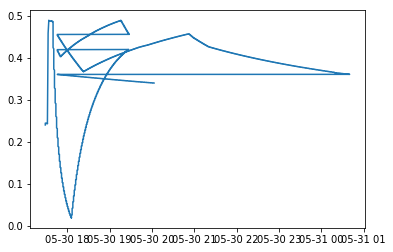

In [9]:
x = data.index
y = data["Carga AH"]

plt.plot(x,y)

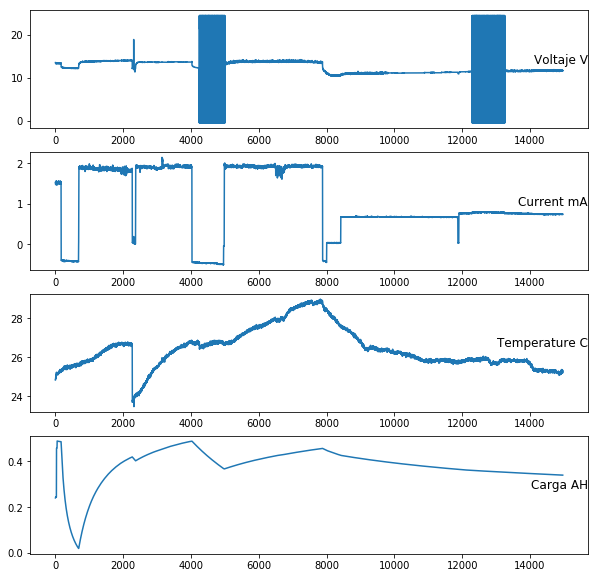

In [10]:
values = data.values

groups = np.arange(0,4,1)
tam = groups.size
plot = 1
plt.figure(figsize=(10,10))
for group in groups:
    plt.subplot(tam, 1, plot)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y =0.5, loc='right')
    plot += 1
plt.show()

In [11]:
data.drop(data.index[4000:5000], inplace=True)
data.drop(data.index[9000:9500], inplace=True)
data.shape

(9622, 4)

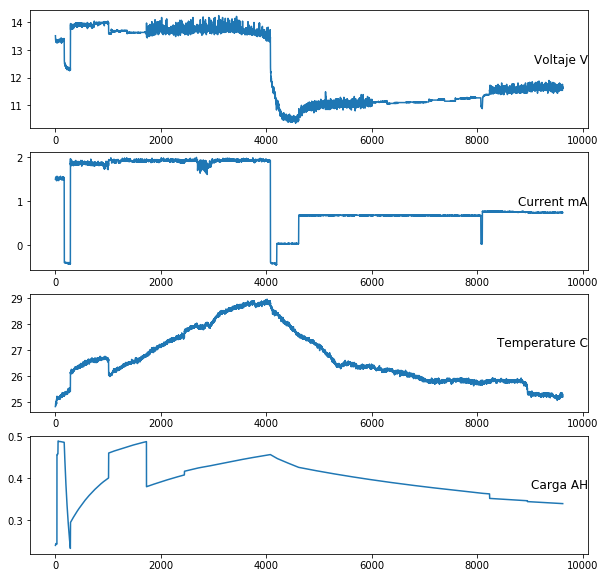

In [12]:
values = data.values

groups = np.arange(0,4,1)
tam = groups.size
plot = 1
plt.figure(figsize=(10,10))
for group in groups:
    plt.subplot(tam, 1, plot)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y =0.5, loc='right')
    plot += 1
plt.show()

Se crea tres modelos basado en las RNNs convencionales, una LSTM y por último basado en unidades GRU. Se busca hacer comparación del rendimiento de los modelos.

In [13]:
def create_datasetMultipleTimesBackAhead(dataset, n_steps_out=1, n_steps_in = 1, overlap = 1,index_feature_pred = None):  
    dataX, dataY = [], []
    tem = n_steps_in + n_steps_out - overlap
    for i in range(int((len(dataset) - tem)/overlap)):
        startx = i*overlap
        endx = startx + n_steps_in
        starty = endx       
        endy = endx + n_steps_out     
        a = dataset[startx:endx, :]
        dataX.append(a)      
        dataY.append(dataset[starty:endy, index_feature_pred])
    return np.array(dataX), np.array(dataY)

In [14]:
def get_dataset_multiples_times(train,test,n_steps_out,n_steps_in,overlap,index_feature_pred=0):
    Xtrain, ytrain = create_datasetMultipleTimesBackAhead(train, n_steps_out, n_steps_in, overlap, index_feature_pred)
    Xtest, ytest = create_datasetMultipleTimesBackAhead(test, n_steps_out, n_steps_in, overlap, index_feature_pred)
    return Xtrain,ytrain,Xtest,ytest

In [15]:
def model_RNN(Xtrain, ytrain, Xtest, ytest, n_features, n_steps=1):
    
    model = Sequential()
    model.add(SimpleRNN(30,activation = 'relu',input_shape=(n_features,n_steps)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc'])
    
    model.fit(Xtrain,ytrain[:,0].flatten(),epochs=10, verbose=1)

    metricsTrain = model.evaluate(Xtrain, ytrain)
    metricsTest = model.evaluate(Xtest,ytest)
    return metricsTrain, metricsTest, model

In [16]:
def model_LSTM(Xtrain, ytrain, Xtest,ytest, n_features,  n_steps=1):
    
    #Construcción de la arquitectura
    model = Sequential()
    model.add(LSTM(30,activation = 'relu', input_shape=(n_features,n_steps)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc'])
    
    model.fit(Xtrain,ytrain[:,0].flatten(),epochs=10, verbose=1)

    metricsTrain = model.evaluate(Xtrain, ytrain)
    metricsTest = model.evaluate(Xtest,ytest)
    return metricsTrain, metricsTest, model

In [17]:
def model_GRU(Xtrain,ytrain,Xtest, ytest,n_features, n_steps=1):
    
    model = Sequential()
    model.add(GRU(50,activation = 'relu',input_shape=(n_features,n_steps)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc'])
    
    model.fit(Xtrain,ytrain[:,0].flatten(),epochs=10, verbose=1)

    metricsTrain = model.evaluate(Xtrain, ytrain)
    metricsTest = model.evaluate(Xtest,ytest)
    return metricsTrain, metricsTest, model

In [18]:
def plot_metrics(title, metrics):
    x = np.arange(1,n_steps_in)
    plt.figure(figsize=(15,15))
    plt.suptitle(title, size=16)
    legends = ["Loss","Mean absolute error","Accuracy"]
    plot = 1
    tam =6

    for train,test in metrics:
        plt.subplot(tam, 1, plot)
        plt.plot(x,train, label="Train")
        plt.plot(x, test, 'r', label = "Test")
        plt.title(legends[plot-1]+" train vs test", y = 0.5)
        plt.legend()
        plot+= 1


    plt.show()

In [19]:
def run_model(trainN, testN, type_model=1,n_steps_in=6, n_steps_out = 1):
    n_features = trainN.shape[1]
   
    overlap=1
    lossTest, lossTrain=[], []
    accTest, accTrain = [], []
    mseTest, mseTrain = [], []

   
    for i in range(1,n_steps_in):
        n_steps_in=i
        Xtrain, ytrain, Xtest, ytest = get_dataset_multiples_times(trainN, testN, n_steps_out, n_steps_in, overlap, index_feature_pred=0)
        print("Xtrain shape: ", Xtrain.shape)
        print("ytrain: ",ytrain.shape)
        print("Steps in: ",n_steps_in)

        if type_model == 1:
            print("RNN")
            metricsTrain, metricsTest, model = model_RNN(Xtrain, ytrain, Xtest, ytest, n_steps_in, n_features)
           
        elif type_model == 2:
            print("LSTM")
            metricsTrain, metricsTest, model = model_LSTM(Xtrain, ytrain, Xtest,ytest, n_steps_in, n_features)
         
        elif type_model == 3:
            print("GRU")
            metricsTrain, metricsTest, model = model_GRU(Xtrain, ytrain, Xtest,ytest, n_steps_in, n_features)
            
            
        lossTrain  += [metricsTrain[0]]
        lossTest  += [metricsTest[0]]
        mseTrain  += [metricsTrain[1]]
        mseTest  += [metricsTest[1]]
        accTrain  += [metricsTrain[2]]
        accTest  += [metricsTest[2]]
    return [(lossTrain, lossTest), (mseTrain, mseTest), (accTrain, accTest)]
   

In [20]:
train, test = train_test_split(data, test_size=0.3)
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
print ("Datos escalados: ","testN",testN.shape, "trainN",trainN.shape)
n_steps_in = 6


Datos escalados:  testN (2887, 4) trainN (6735, 4)


In [21]:
metrics = run_model(trainN, testN,1)


Xtrain shape:  (6734, 1, 4)
ytrain:  (6734, 1)
Steps in:  1
RNN
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
6734/6734 [==============================] - 3s 473us/step - loss: 0.1551 - mean_absolute_error: 0.3375 - acc: 2.9700e-04
Epoch 2/10
6734/6734 [==============================] - 1s 115us/step - loss: 0.1121 - mean_absolute_error: 0.3162 - acc: 4.4550e-04
Epoch 3/10
6734/6734 [==============================] - 1s 167us/step - loss: 0.1103 - mean_absolute_error: 0.3164 - acc: 4.4550e-04
Epoch 4/10
6734/6734 [==============================] - 1s 122us/step - loss: 0.1100 - mean_absolute_error: 0.3170 - acc: 2.9700e-04
Epoch 5/10
6734/6734 [==============================] - 1s 130us/step - loss: 0.1097 - mean_absolute_error: 0.3166 - acc: 4.4550e-04
Epoch 6/10
6734/6734 [==============================] - 1s 118us/step - loss: 0.1098 - mean_absolute_error: 0.3171 - acc: 4.4550e-04
Epoch 7/10
6734/67

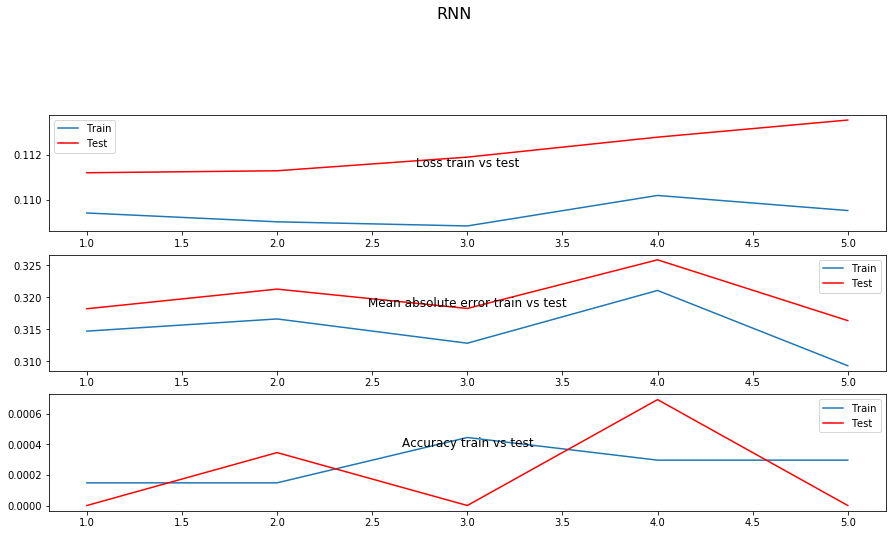

In [ ]:
plot_metrics("RNN",metrics)

In [ ]:
metrics_lstm = run_model(trainN, testN,2)


Xtrain shape:  (6734, 1, 4)
ytrain:  (6734, 1)
Steps in:  1
LSTM
Epoch 1/10
6734/6734 [==============================] - 5s 795us/step - loss: 0.1588 - mean_absolute_error: 0.3304 - acc: 2.9700e-04
Epoch 2/10
6734/6734 [==============================] - 2s 287us/step - loss: 0.1144 - mean_absolute_error: 0.3144 - acc: 5.9400e-04
Epoch 3/10
6734/6734 [==============================] - 2s 262us/step - loss: 0.1110 - mean_absolute_error: 0.3159 - acc: 4.4550e-04
Epoch 4/10
6734/6734 [==============================] - 2s 231us/step - loss: 0.1103 - mean_absolute_error: 0.3167 - acc: 2.9700e-04
Epoch 5/10
6734/6734 [==============================] - 2s 313us/step - loss: 0.1099 - mean_absolute_error: 0.3167 - acc: 4.4550e-04
Epoch 6/10
6734/6734 [==============================] - 2s 275us/step - loss: 0.1096 - mean_absolute_error: 0.3164 - acc: 2.9700e-04
Epoch 7/10
6734/6734 [==============================] - 2s 251us/step - loss: 0.1096 - mean_absolute_error: 0.3171 - acc: 5.9400e-04
Epoc

In [ ]:
plot_metrics("LSTM", metrics_lstm)

In [ ]:
metrics_gru = run_model(trainN, testN,3)


In [ ]:
plot_metrics("GRU",metrics_gru)